### Домашнее задание 2

Выполнил Козин Роман

Для начала отберём 10 классов для работы с ними

In [1]:
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np

In [2]:
import random
import torch
random.seed(52)
torch.manual_seed(52)
np.random.seed(52)
CLASS_NUM = 10
classes_path = './data/tiny-imagenet-200/tiny-imagenet-200/wnids.txt'
with open(classes_path) as f:
    ids = f.read().split('\n')
print(ids)

['n02124075', 'n04067472', 'n04540053', 'n04099969', 'n07749582', 'n01641577', 'n02802426', 'n09246464', 'n07920052', 'n03970156', 'n03891332', 'n02106662', 'n03201208', 'n02279972', 'n02132136', 'n04146614', 'n07873807', 'n02364673', 'n04507155', 'n03854065', 'n03838899', 'n03733131', 'n01443537', 'n07875152', 'n03544143', 'n09428293', 'n03085013', 'n02437312', 'n07614500', 'n03804744', 'n04265275', 'n02963159', 'n02486410', 'n01944390', 'n09256479', 'n02058221', 'n04275548', 'n02321529', 'n02769748', 'n02099712', 'n07695742', 'n02056570', 'n02281406', 'n01774750', 'n02509815', 'n03983396', 'n07753592', 'n04254777', 'n02233338', 'n04008634', 'n02823428', 'n02236044', 'n03393912', 'n07583066', 'n04074963', 'n01629819', 'n09332890', 'n02481823', 'n03902125', 'n03404251', 'n09193705', 'n03637318', 'n04456115', 'n02666196', 'n03796401', 'n02795169', 'n02123045', 'n01855672', 'n01882714', 'n02917067', 'n02988304', 'n04398044', 'n02843684', 'n02423022', 'n02669723', 'n04465501', 'n02165456'

Возьмём случайные десять классов, в исходном текстовом файле была пустая строка, учтём это при отборе случайных классов

In [3]:
selected_classes = random.sample(ids[:-1], CLASS_NUM)
print(selected_classes)

['n01882714', 'n02279972', 'n02699494', 'n02123394', 'n03026506', 'n01910747', 'n04532106', 'n07920052', 'n02058221', 'n07695742']


Вот наши классы, чтобы случайно не потерять их, выпишем их в список явно

In [4]:
selected_classes = ['n01882714', 'n02279972', 'n02699494', 'n02123394', 'n03026506', 'n01910747', 'n04532106', 'n07920052', 'n02058221', 'n07695742']

## Часть 1: Подготовка данных

Создание датакласса
Реализуйте собственный класс TinyImageNetDataset, наследующий от torch.utils.data.Dataset:

* Метод ```__init__```: инициализация путей к данным, загрузка списка изображений и меток
* Метод ```__len__```: возврат количества примеров в датасете
* Метод ```__getitem__```: загрузка и возврат одного примера (изображение + метка)

In [5]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import torch
import os
class SmallDataset(Dataset):
    def __init__(self, root: str, classes: list[str], ds_type: str, device = torch.device("cpu"), transform = None) -> None:
        super().__init__()
        self.ds_type = ds_type
        self.root = root
        self.classes = classes
        if ds_type == 'val':
            self.prepareValData()
        self.device = device
        self.transform = transform
        self.label_to_idx = {label : idx for idx, label in enumerate(classes)}
        
    def prepareValData(self) -> None:
        self.valData = []
        labelsSet = set(self.classes)
        with open(os.path.join(self.root, self.ds_type, "val_annotations.txt")) as f:
            rows = f.readlines()
            f.close()    
        for row in rows:
            data = self._parseLine(row)
            label = data[1]
            if label in labelsSet:
                self.valData.append(tuple(data))
    
    def _parseLine(self, row: str):
        els = row.split("\t")
        data = [els[k].strip("\n") for k in range(len(els))]
        if self.ds_type == 'val':
            start_idx = 2
        else:
            start_idx = 1
        for i in range(start_idx, len(data)):
            data[i] = int(data[i])
        return data
    
    def __getitem__(self, index: int):
        if self.ds_type == 'val':
            data = self.valData[index]
            img_path = os.path.join(self.root, self.ds_type, "images", data[0])
            label = data[1]
            bbox = tuple(data[2:])
        else:
            label_idx = index // 500
            img_idx = index % 500
            label = self.classes[label_idx]
            label_root = os.path.join(self.root, self.ds_type, label)
            img_path = os.path.join(label_root, "images", f'{label}_{img_idx}.JPEG')
            with open(os.path.join(label_root, f"{label}_boxes.txt")) as f:
                rows = f.readlines()
                f.close()
            row = rows[img_idx]
            data = self._parseLine(row)
            bbox = tuple(data[1:])
        
        bbox = torch.tensor(bbox).to(self.device)
        img = Image.open(img_path).convert('RGB')
            
        if self.transform:
            img = self.transform(img)
        return (img.to(self.device), torch.tensor(self.label_to_idx[label]).to(self.device), bbox)
        
    def __len__(self) -> int:
        #структура исходного датасета такова, что на каждый класс приходится 500 изображений
        if self.ds_type == 'train':
            return len(self.classes) * 500
        else:
            return len(self.valData)

In [6]:
ds = SmallDataset("data\\tiny-imagenet-200\\tiny-imagenet-200", classes=selected_classes, ds_type='train')

## Часть 2: Базовая архитектура ResNet18

### 2.1. Реализация Basic Block

Создайте базовый residual блок со следующей структурой:

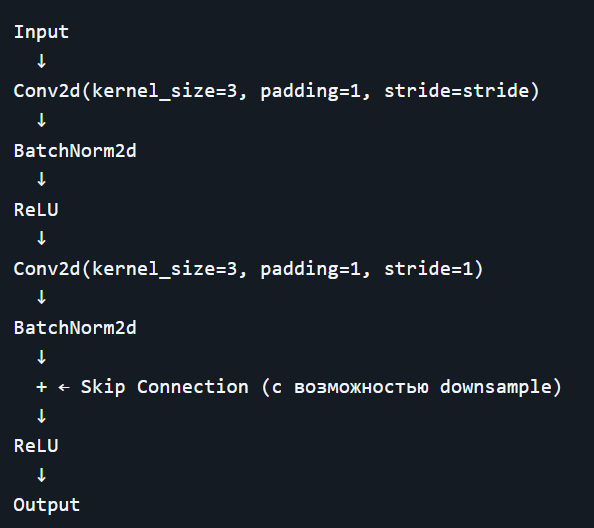

Важно:

* Если входные и выходные размерности не совпадают, используйте skip connection с Conv2d(1x1) + BatchNorm2d
* Первый residual блок может иметь stride=2 для уменьшения пространственного размера

In [7]:
import torch.nn as nn

class BasicResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = None
        if in_channels != out_channels or stride > 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()
            
    def forward(self, x):
        identity = x
        res = self.conv1(x)
        res = self.conv2(res)
        if self.downsample:
            identity = self.downsample(identity)
        res = res + identity
        res = self.relu(res)
        return res

In [8]:
x = torch.randn(1, 3, 64, 64)

model = BasicResBlock(3, 16, stride=2)
print(model(x).shape)

torch.Size([1, 16, 32, 32])


### 2.2 Реализация ResNet18

Создайте архитектуру ResNet18 со следующей структурой:

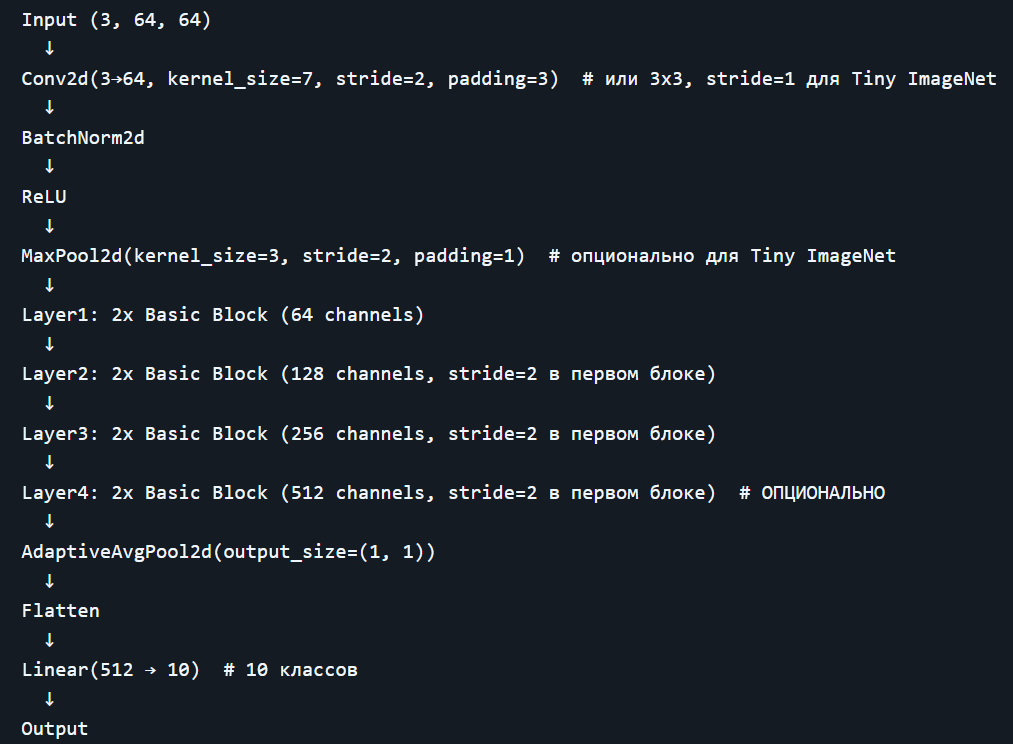

Сделаем без самой первой свёртки, так как она необязательная

In [9]:
class ResNet18(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Sequential(    #64, 32, 32
            BasicResBlock(in_channels=3, out_channels=3, stride=2),
            BasicResBlock(in_channels=3, out_channels=64, stride=1),
        )
        self.layer2 = nn.Sequential(    #128, 16, 16
            BasicResBlock(in_channels=64, out_channels=64, stride=2),
            BasicResBlock(in_channels=64, out_channels=128, stride=1)
        )
        self.layer3 = nn.Sequential(    #256, 8, 8
            BasicResBlock(in_channels=128, out_channels=128, stride=2),
            BasicResBlock(in_channels=128, out_channels=256, stride=1)
        )
        self.layer4 = nn.Sequential(    #512, 4, 4
            BasicResBlock(in_channels=256, out_channels=256, stride=2),
            BasicResBlock(in_channels=256, out_channels=512, stride=1)
        )
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=512, out_features=10)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg(self.layer4(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [10]:
from torchsummary import summary

In [11]:
x = torch.randn((1, 3, 64, 64))
model = ResNet18()
print(model(x).shape)
summary(model, input_size=(3, 64, 64), batch_size=1)

torch.Size([1, 10])
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              90
|    |    └─Sequential: 3-2              90
|    |    └─Sequential: 3-3              18
|    |    └─ReLU: 3-4                    --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              90
|    |    └─Sequential: 3-6              1,920
|    |    └─Sequential: 3-7              384
|    |    └─ReLU: 3-8                    --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              37,056
|    |    └─Sequential: 3-10             37,056
|    |    └─Sequential: 3-11             4,288
|    |    └─ReLU: 3-12                   --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-13             37,056
|    |    └─Sequential: 3-14             74,112
|    |    └─Sequential: 3-15

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              90
|    |    └─Sequential: 3-2              90
|    |    └─Sequential: 3-3              18
|    |    └─ReLU: 3-4                    --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              90
|    |    └─Sequential: 3-6              1,920
|    |    └─Sequential: 3-7              384
|    |    └─ReLU: 3-8                    --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              37,056
|    |    └─Sequential: 3-10             37,056
|    |    └─Sequential: 3-11             4,288
|    |    └─ReLU: 3-12                   --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-13             37,056
|    |    └─Sequential: 3-14             74,112
|    |    └─Sequential: 3-15             8,576
|

Итого параметров меньше 5 млн. Важно отметить, что условие на число параметров удалось соблюсти благодаря тому, что изменение количества каналов происходит в последнем блоке. То же самое происходит внутри базового блока, каналы изменяются в последней свёртке. Для простоты сравнения будем везде придерживаться такой структуры

### Обучение

In [12]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

In [13]:
transforms_list = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], #найденные в интернете параметры для imagenet
                        std=[0.229, 0.224, 0.225])
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_root = "./data/tiny-imagenet-200/tiny-imagenet-200"
train_data = SmallDataset(root=data_root, classes=selected_classes,
                          ds_type='train', transform=transforms_list, device=device)
val_data = SmallDataset(root=data_root, classes=selected_classes,
                        ds_type='val', transform=transforms_list, device=device)
train_data_loader = DataLoader(train_data,batch_size=16, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=16, shuffle=True)
model = ResNet18().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

Цикл обучения

In [14]:
from copy import deepcopy
from tqdm import tqdm

def train_one_run(model, optimizer, criterion, train_data_loader, val_data_loader, epoch_num=20):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_val_acc = 0.0
    best_state_dict = None
    train_acc = None

    for epoch in range(epoch_num):
        train_correct = 0
        train_predicted = 0
        model.train()
        
        for images, labels, _ in tqdm(desc=f"Training epoch {epoch + 1}", iterable=train_data_loader):
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            preds = logits.argmax(dim=-1)
            train_correct += (preds == labels).sum().item()
            train_predicted += labels.size(0)
        
        train_loss_history.append(loss.item())
        train_acc_history.append(train_correct / train_predicted)

        model.eval()
        val_correct = 0
        val_predicted = 0
        
        with torch.no_grad():
            for images, labels, _ in tqdm(iterable=val_data_loader, desc=f"Validating"):
                logits = model(images)
                loss = criterion(logits, labels)
                preds = logits.argmax(dim=-1)
                val_correct += (preds == labels).sum().item()
                val_predicted += labels.size(0)
            
            val_loss_history.append(loss.item())
            val_acc = val_correct / val_predicted
            val_acc_history.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = deepcopy(model.state_dict())
            train_acc = train_correct / train_predicted

    return {
        "best_state_dict": best_state_dict,
        "best_val_acc": best_val_acc,
        "best_train_acc" : train_acc,
        "train_loss_history": train_loss_history,
        "val_loss_history": val_loss_history,
        "train_acc_history": train_acc_history,
        "val_acc_history": val_acc_history,
    }


def train_multiple_runs(runs, model_constructor, optimizer_constructor, criterion, train_data_loader, val_data_loader, epoch_num=20):
    all_train_losses = []
    all_val_losses = []
    all_train_accs = []
    all_val_accs = []

    best_overall_val_acc = 0.0
    best_overall_state_dict = None

    for run in range(runs):
        print(f"\n===== Run {run + 1}/{runs} =====")
        model = model_constructor()
        optimizer = optimizer_constructor(model)

        result = train_one_run(
            model=model,
            optimizer=optimizer,
            criterion=criterion,
            train_data_loader=train_data_loader,
            val_data_loader=val_data_loader,
            epoch_num=epoch_num,
        )

        all_train_losses.append(result["train_loss_history"])
        all_val_losses.append(result["val_loss_history"])
        all_train_accs.append(result["train_acc_history"])
        all_val_accs.append(result["val_acc_history"])

        if result["best_val_acc"] > best_overall_val_acc:
            best_overall_val_acc = result["best_val_acc"]
            best_overall_state_dict = deepcopy(result["best_state_dict"])

    mean_train_losses = np.mean(np.array(all_train_losses), axis=0)
    mean_val_losses = np.mean(np.array(all_val_losses), axis=0)
    mean_train_accs = np.mean(np.array(all_train_accs), axis=0)
    mean_val_accs = np.mean(np.array(all_val_accs), axis=0)

    best_model = model_constructor()
    best_model.load_state_dict(best_overall_state_dict)

    return {
        "best_model": best_model,                    
        "best_val_acc": best_overall_val_acc,        
        "mean_train_losses": mean_train_losses,      
        "mean_val_losses": mean_val_losses,
        "mean_train_accs": mean_train_accs,
        "mean_val_accs": mean_val_accs,
        "all_histories": {
            "train_losses": all_train_losses,
            "val_losses": all_val_losses,
            "train_accs": all_train_accs,
            "val_accs": all_val_accs,
        },
    }


In [15]:
def makeResNet():
    return ResNet18().to(device)

def make_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
results = train_multiple_runs(
    runs=1,
    model_constructor=makeResNet,
    optimizer_constructor=make_optimizer,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=20,
)


===== Run 1/1 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 64.38it/s]


In [17]:
best_model = results["best_model"]
mean_train_losses = results["mean_train_losses"]
mean_val_losses = results["mean_val_losses"]
mean_train_accs = results["mean_train_accs"]
mean_val_accs = results["mean_val_accs"]

In [18]:
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np

[]

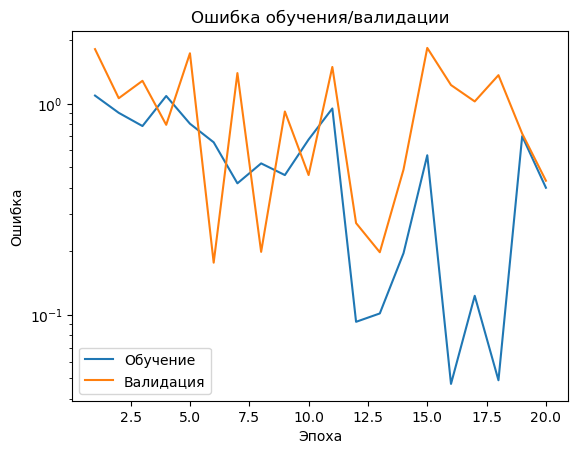

In [19]:
plt.title('Ошибка обучения/валидации')
plt.plot(np.arange(1, len(mean_train_losses)+1, dtype=np.int16), mean_train_losses, label='Обучение')
plt.plot(np.arange(1, len(mean_val_losses)+1, dtype=np.int16), mean_val_losses, label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()
plt.semilogy()

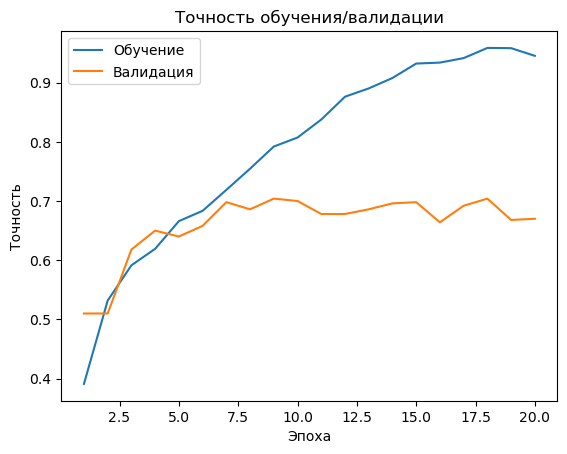

In [20]:
plt.title('Точность обучения/валидации')
plt.plot(np.arange(1, len(mean_train_accs)+1, dtype=np.int16), mean_train_accs, label='Обучение')
plt.plot(np.arange(1, len(mean_val_accs)+1, dtype=np.int16), mean_val_accs, label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

### Наблюдение

На графике ошибке по эпохам сложно увидеть, происходит обучение или нет, но если смотреть на точность, то можно увидеть, что точность растёт при обучении, но точность валидации в один момент выходит на плато. Возьмём лучшую модель по точности на валидации

Итоговая модель на этом этапе:

In [21]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              90
|    |    └─Sequential: 3-2              90
|    |    └─Sequential: 3-3              18
|    |    └─ReLU: 3-4                    --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              90
|    |    └─Sequential: 3-6              1,920
|    |    └─Sequential: 3-7              384
|    |    └─ReLU: 3-8                    --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              37,056
|    |    └─Sequential: 3-10             37,056
|    |    └─Sequential: 3-11             4,288
|    |    └─ReLU: 3-12                   --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-13             37,056
|    |    └─Sequential: 3-14             74,112
|    |    └─Sequential: 3-15             8,576
|

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              90
|    |    └─Sequential: 3-2              90
|    |    └─Sequential: 3-3              18
|    |    └─ReLU: 3-4                    --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              90
|    |    └─Sequential: 3-6              1,920
|    |    └─Sequential: 3-7              384
|    |    └─ReLU: 3-8                    --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              37,056
|    |    └─Sequential: 3-10             37,056
|    |    └─Sequential: 3-11             4,288
|    |    └─ReLU: 3-12                   --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-13             37,056
|    |    └─Sequential: 3-14             74,112
|    |    └─Sequential: 3-15             8,576
|

## 3 Поэтапная оптимизация модели

### 3.1: Оптимизация количества каналов

Цель: Изучение влияния количества каналов на производительность.

Эксперимент:

Создайте 2 варианта модели:
* Вариант A: 32 → 64 → 128 → 256 каналов
* Вариант B: 64 → 128 → 256 каналов (без 4-го слоя)

Обучите обе модели с теми же гиперпараметрами

Сравните:
* Количество параметров
* Validation accuracy

In [22]:
class ResNetA(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Sequential(    #32, 32, 32
            BasicResBlock(in_channels=3, out_channels=3, stride=2),
            BasicResBlock(in_channels=3, out_channels=32, stride=1),
        )
        self.layer2 = nn.Sequential(    #64, 16, 16
            BasicResBlock(in_channels=32, out_channels=32, stride=2),
            BasicResBlock(in_channels=32, out_channels=64, stride=1)
        )
        self.layer3 = nn.Sequential(    #128, 8, 8
            BasicResBlock(in_channels=64, out_channels=64, stride=2),
            BasicResBlock(in_channels=64, out_channels=128, stride=1)
        )
        
        self.layer4 = nn.Sequential(    #256, 4, 4
            BasicResBlock(in_channels=128, out_channels=128, stride=2),
            BasicResBlock(in_channels=128, out_channels=256, stride=1)
        )
        
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=10)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg(self.layer4(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [23]:
summary(ResNetA())

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              90
|    |    └─Sequential: 3-2              90
|    |    └─Sequential: 3-3              18
|    |    └─ReLU: 3-4                    --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              90
|    |    └─Sequential: 3-6              960
|    |    └─Sequential: 3-7              192
|    |    └─ReLU: 3-8                    --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              9,312
|    |    └─Sequential: 3-10             9,312
|    |    └─Sequential: 3-11             1,120
|    |    └─ReLU: 3-12                   --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-13             9,312
|    |    └─Sequential: 3-14             18,624
|    |    └─Sequential: 3-15             2,240
|    |

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              90
|    |    └─Sequential: 3-2              90
|    |    └─Sequential: 3-3              18
|    |    └─ReLU: 3-4                    --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              90
|    |    └─Sequential: 3-6              960
|    |    └─Sequential: 3-7              192
|    |    └─ReLU: 3-8                    --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              9,312
|    |    └─Sequential: 3-10             9,312
|    |    └─Sequential: 3-11             1,120
|    |    └─ReLU: 3-12                   --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-13             9,312
|    |    └─Sequential: 3-14             18,624
|    |    └─Sequential: 3-15             2,240
|    |

In [24]:
model = ResNetA().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [25]:
def makeModelA():
    return ResNetA().to(device)

In [27]:
resultsA = train_multiple_runs(
    runs=3,
    model_constructor=makeModelA,
    optimizer_constructor=make_optimizer,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=20,
)


===== Run 1/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 44.68it/s]



===== Run 2/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 47.12it/s]



===== Run 3/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 45.47it/s]


In [28]:
class ResNetB(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Sequential(    #64, 32, 32
            BasicResBlock(in_channels=3, out_channels=3, stride=2),
            BasicResBlock(in_channels=3, out_channels=64, stride=1),
        )
        self.layer2 = nn.Sequential(    #128, 16, 16
            BasicResBlock(in_channels=64, out_channels=64, stride=2),
            BasicResBlock(in_channels=64, out_channels=128, stride=1)
        )
        self.layer3 = nn.Sequential(    #256, 8, 8
            BasicResBlock(in_channels=128, out_channels=128, stride=2),
            BasicResBlock(in_channels=128, out_channels=256, stride=1)
        )
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=10)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [29]:
summary(ResNetB())

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              90
|    |    └─Sequential: 3-2              90
|    |    └─Sequential: 3-3              18
|    |    └─ReLU: 3-4                    --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              90
|    |    └─Sequential: 3-6              1,920
|    |    └─Sequential: 3-7              384
|    |    └─ReLU: 3-8                    --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              37,056
|    |    └─Sequential: 3-10             37,056
|    |    └─Sequential: 3-11             4,288
|    |    └─ReLU: 3-12                   --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-13             37,056
|    |    └─Sequential: 3-14             74,112
|    |    └─Sequential: 3-15             8,576
|

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─BasicResBlock: 2-1                --
|    |    └─Sequential: 3-1              90
|    |    └─Sequential: 3-2              90
|    |    └─Sequential: 3-3              18
|    |    └─ReLU: 3-4                    --
|    └─BasicResBlock: 2-2                --
|    |    └─Sequential: 3-5              90
|    |    └─Sequential: 3-6              1,920
|    |    └─Sequential: 3-7              384
|    |    └─ReLU: 3-8                    --
├─Sequential: 1-2                        --
|    └─BasicResBlock: 2-3                --
|    |    └─Sequential: 3-9              37,056
|    |    └─Sequential: 3-10             37,056
|    |    └─Sequential: 3-11             4,288
|    |    └─ReLU: 3-12                   --
|    └─BasicResBlock: 2-4                --
|    |    └─Sequential: 3-13             37,056
|    |    └─Sequential: 3-14             74,112
|    |    └─Sequential: 3-15             8,576
|

In [30]:
def makeModelB():
    return ResNetB().to(device)

In [31]:
resultsB = train_multiple_runs(
    runs=3,
    model_constructor=makeModelB,
    optimizer_constructor=make_optimizer,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=20,
)


===== Run 1/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 48.94it/s]



===== Run 2/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 47.24it/s]



===== Run 3/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 48.06it/s]


Сравним точность моделей

In [32]:
a_val_acc = resultsA['mean_val_accs']
b_val_acc = resultsB['mean_val_accs']

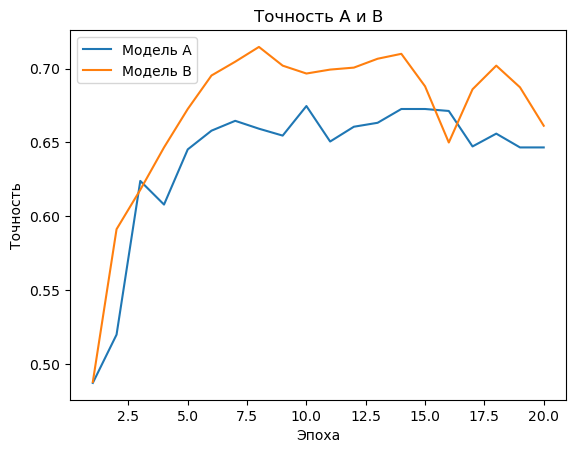

In [33]:
plt.title('Точность А и В')
plt.plot(np.arange(1, len(a_val_acc)+1, dtype=np.int16), a_val_acc, label='Модель А')
plt.plot(np.arange(1, len(b_val_acc)+1, dtype=np.int16), b_val_acc, label='Модель В')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

In [34]:
print("Точность модели А:", resultsA['best_val_acc'])
print("Точность модели B", resultsB['best_val_acc'])

Точность модели А: 0.708
Точность модели B 0.746


Обучение моделей

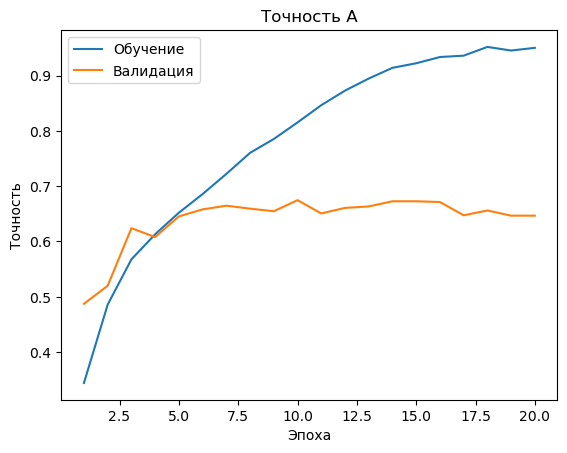

In [88]:
plt.title('Точность А')
plt.plot(np.arange(1, 20+1, dtype=np.int16), resultsA['mean_train_accs'], label='Обучение')
plt.plot(np.arange(1, 20+1, dtype=np.int16), resultsA['mean_val_accs'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

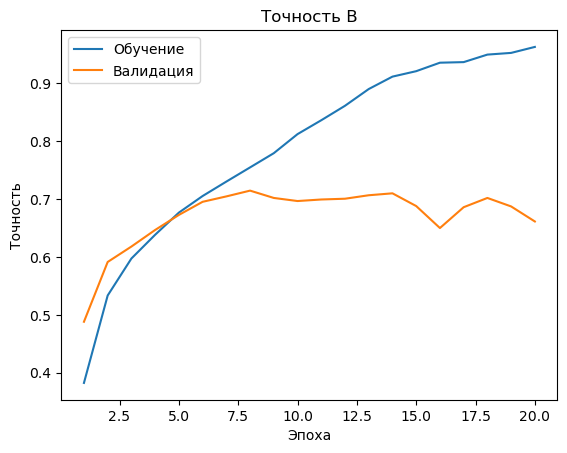

In [89]:
plt.title('Точность B')
plt.plot(np.arange(1, 20+1, dtype=np.int16), resultsB['mean_train_accs'], label='Обучение')
plt.plot(np.arange(1, 20+1, dtype=np.int16), resultsB['mean_val_accs'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

### Сравнительная таблица

| Модель | Параметры | Точность |
|---|---:|---:|
| ResNetA | 1,041,578 | 70.8% |
| ResNetB | 992,810 | 74.6% |


По итогу модель B оказалась получше

Можно сделать вывод, что менее глубокая модель, но с тем же количеством итоговых признаков (каналов) перед применением линейного слоя, оказалась эффективнее. Это может быть связано с тем, что первые слои имеют более обширные признаки. При этом мы не сильно изменили количество параметров (на 5%).

### 3.2: Эксперименты с количеством residual блоков

Цель: Изучение влияния глубины сети (количества residual блоков) на производительность.

Эксперимент:

Используйте лучшую конфигурацию каналов из Этапа 3.1

Создайте 3 варианта модели с разным количеством блоков в каждом слое:
* Вариант A: [1, 1, 1, 1] - по 1 блоку в каждом слое (мелкая сеть)
* Вариант B: [2, 2, 2, 2] - по 2 блока в каждом слое (стандартная ResNet18)
* Вариант C: [3, 3, 3, 3] - по 3 блока в каждом слое (глубокая сеть)

Обучите все три модели с одинаковыми гиперпараметрами

За основу возьмём модель B, будем использовать три слоя и менять количество блоков в каждом из слоёв. Сделаем следующим образом: в первом блоке снижаем разрешение изображения, а в последующих нет. Количество каналов изменяем только в последнем слое (как было оговорено при моей реализации ResNet18)

In [35]:
class ShallowLayer(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = BasicResBlock(in_channels, out_channels, stride=2)
        
    def forward(self, x):
        return self.layer(x)

class ShallowResNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = ShallowLayer(in_channels=3, out_channels=64) #64, 32, 32
        self.layer2 = ShallowLayer(in_channels=64, out_channels=128) #128 16, 16
        self.layer3 = ShallowLayer(in_channels=128, out_channels=256) # 256, 8, 8
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [36]:
model = ShallowResNet()
param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Число параметров: ", param_num)

Число параметров:  601764


In [37]:
class MidLayer(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = nn.Sequential(
            BasicResBlock(in_channels, in_channels, stride=2),
            BasicResBlock(in_channels, out_channels)
        )
    def forward(self, x):
        return self.layer(x)
    
class MidResNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = MidLayer(3, 64) #64, 32, 32
        self.layer2 = MidLayer(64, 128) #128, 16, 16
        self.layer3 = MidLayer(128, 256) #256, 8, 8
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [38]:
model = MidResNet()
param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Число параметров: ", param_num)

Число параметров:  992810


In [39]:
class DeepLayer(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = nn.Sequential(
            BasicResBlock(in_channels, in_channels, stride=2),
            BasicResBlock(in_channels, in_channels),
            BasicResBlock(in_channels, out_channels)
        )
    def forward(self, x):
        return self.layer(x)
    
class DeepResNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = DeepLayer(3, 64) #64, 32, 32
        self.layer2 = DeepLayer(64, 128) #128, 16, 16
        self.layer3 = DeepLayer(128, 256) #256, 8, 8
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [40]:
model = DeepResNet()
param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Число параметров: ", param_num)

Число параметров:  1362782


Теперь обучим все модели

In [41]:
def makeShallow():
    return ShallowResNet().to(device)

resultsShallow = train_multiple_runs(
    runs=3,
    model_constructor=makeShallow,
    optimizer_constructor=make_optimizer,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=20,
)


===== Run 1/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 48.39it/s]



===== Run 2/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 48.56it/s]



===== Run 3/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 46.83it/s]


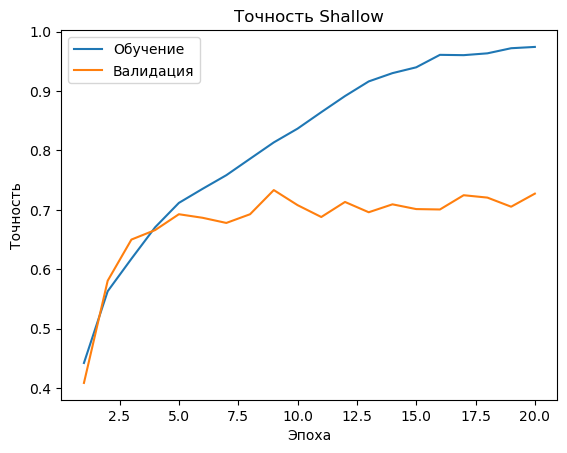

In [90]:
plt.title('Точность Shallow')
plt.plot(np.arange(1, 20+1, dtype=np.int16), resultsShallow['mean_train_accs'], label='Обучение')
plt.plot(np.arange(1, 20+1, dtype=np.int16), resultsShallow['mean_val_accs'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

In [42]:
def makeMid():
    return MidResNet().to(device)

resultsMid = train_multiple_runs(
    runs=3,
    model_constructor=makeMid,
    optimizer_constructor=make_optimizer,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=20,
)


===== Run 1/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 62.96it/s]



===== Run 2/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 51.49it/s]



===== Run 3/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 51.62it/s]


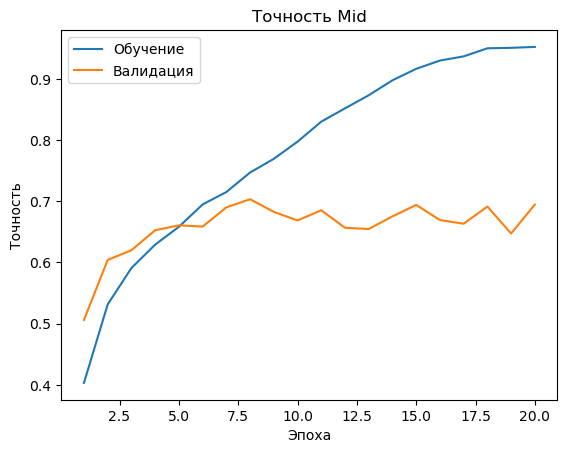

In [91]:
plt.title('Точность Mid')
plt.plot(np.arange(1, 20+1, dtype=np.int16), resultsMid['mean_train_accs'], label='Обучение')
plt.plot(np.arange(1, 20+1, dtype=np.int16), resultsMid['mean_val_accs'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

In [43]:
def makeDeep():
    return DeepResNet().to(device)

resultsDeep = train_multiple_runs(
    runs=3,
    model_constructor=makeDeep,
    optimizer_constructor=make_optimizer,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=20,
)


===== Run 1/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 50.00it/s]



===== Run 2/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 49.17it/s]



===== Run 3/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 49.87it/s]


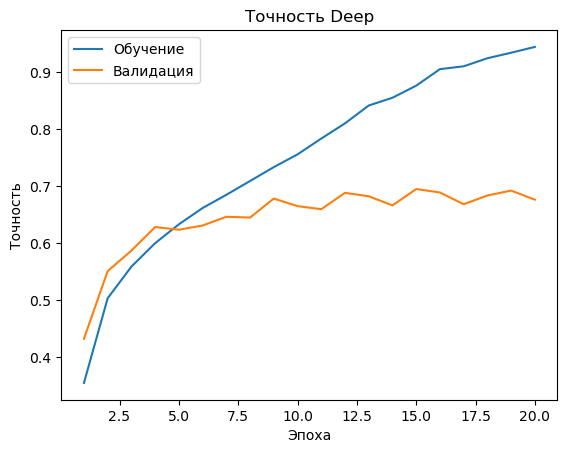

In [92]:
plt.title('Точность Deep')
plt.plot(np.arange(1, 20+1, dtype=np.int16), resultsDeep['mean_train_accs'], label='Обучение')
plt.plot(np.arange(1, 20+1, dtype=np.int16), resultsDeep['mean_val_accs'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

In [44]:
print("Неглубокая сеть: ", resultsShallow['best_val_acc'])
print("Средняя сеть: ", resultsMid['best_val_acc'])
print("Глубокая сеть: ", resultsDeep['best_val_acc'])

Неглубокая сеть:  0.766
Средняя сеть:  0.724
Глубокая сеть:  0.72


Построим графики точности

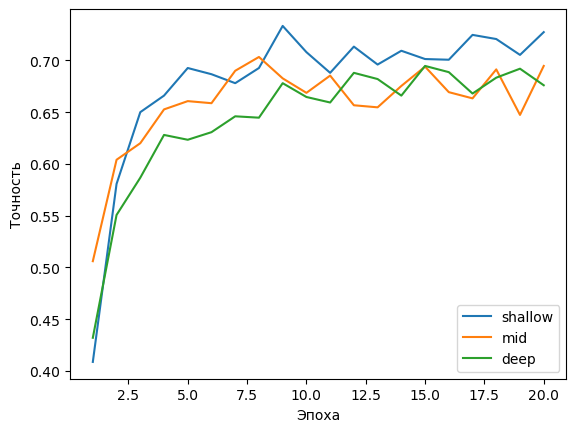

In [45]:
EPOCH_NUM = 20
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), resultsShallow['mean_val_accs'], label = 'shallow')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), resultsMid['mean_val_accs'], label = 'mid')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.int16), resultsDeep['mean_val_accs'], label = 'deep')
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.legend()

Эпоха наилучшего результата:

In [46]:
print("shallow: ", np.argmax(resultsShallow['mean_val_accs']) + 1)
print("mid: ", np.argmax(resultsMid['mean_val_accs']) + 1)
print("deep: ", np.argmax(resultsDeep['mean_val_accs']) + 1)

shallow:  9
mid:  8
deep:  15


Построим сравнительную таблицу

| Модель | Параметры | Точность | Лучшая эпоха
|---|---:|---:|---:|
| ShallowResNet | 601,764 | 76.6% | 9 |
| MidResNet | 992,810 | 72.4% | 8 |
| DeepResNet | 1,362,782 | 72.0% | 15 |


Менее глубокая модель оказалась лучше. Скорее всего это следует из того факта, что изображения не такие уж и большие, из-за чего нет необходимости строить глубокие зависимости. Переобучение на более глубокой модели не наблюдается, она показывает сопоставимые результаты. Опять же стоит отметить, что глубокая модель не настолько глубокая, как могла быть. Всё потому, что мы взяли за основу модель с тремя слоями, так как она показала лучшую эффективность. Если смотреть на усреднённые графики, то они все примерно выходят на плато на одном и том же уровне

## 3.3: Эксперименты с функциями активации

Цель: Исследование влияния различных активаций на обучение.

Модификация модели: Замените ReLU на другие функции активации:

Эксперимент:

* Используйте лучшую конфигурацию из Этапа 3.2 (каналы + количество блоков)
* Обучите модели с разными активациями:
    * Вариант A: ReLU (baseline)
    * Вариант B: LeakyReLU
    * Вариант C: ELU
    * Вариант D: GELU

**Важно**: Используйте inplace=True где возможно для экономии памяти

Результат:

* Сравнение скорости сходимости (accuracy на каждой эпохе)
* Финальная validation accuracy
* Вывод: какая активация работает лучше?

Используем ShallowResNet, так как она показала лучшие результаты

In [ ]:
class BasicResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, activation = nn.ReLU(), *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(in_channels),
            activation
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
        )
        self.downsample = None
        if in_channels != out_channels or stride > 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.activation = activation
            
    def forward(self, x):
        identity = x
        res = self.conv1(x)
        res = self.conv2(res)
        if self.downsample:
            identity = self.downsample(identity)
        res = res + identity
        res = self.activation(res)
        return res

class ShallowLayer(nn.Module):
    def __init__(self, in_channels, out_channels, activation, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = BasicResBlock(in_channels, out_channels, stride=2, activation=activation)
        
    def forward(self, x):
        return self.layer(x)

class ShallowResNet(nn.Module):
    def __init__(self, activation, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = ShallowLayer(in_channels=3, out_channels=64, activation=activation) #64, 32, 32
        self.layer2 = ShallowLayer(in_channels=64, out_channels=128, activation=activation) #128 16, 16
        self.layer3 = ShallowLayer(in_channels=128, out_channels=256, activation=activation) # 256, 8, 8
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Linear(in_features=256, out_features=10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg(self.layer3(x))
        x = x.flatten(1)
        x = self.fc(x)
        return x

Создадим все модели

In [48]:
def makeReLU():
    return ShallowResNet(nn.ReLU()).to(device)
def makeLReLU():
    return ShallowResNet(nn.LeakyReLU()).to(device)
def makeELU():
    return ShallowResNet(nn.ELU()).to(device)
def makeGELU():
    return ShallowResNet(nn.GELU()).to(device)

In [49]:
resultsRELU = train_multiple_runs(
    runs=3,
    model_constructor=makeReLU,
    optimizer_constructor=make_optimizer,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=20,
)


===== Run 1/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 59.06it/s]



===== Run 2/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 49.46it/s]



===== Run 3/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 50.08it/s]


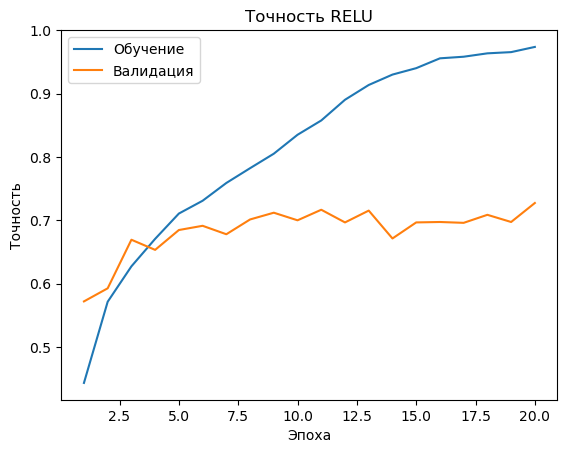

In [93]:
plt.title('Точность RELU')
plt.plot(np.arange(1, 20+1, dtype=np.int16), resultsRELU['mean_train_accs'], label='Обучение')
plt.plot(np.arange(1, 20+1, dtype=np.int16), resultsRELU['mean_val_accs'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

In [50]:
resultsLReLU = train_multiple_runs(
    runs=3,
    model_constructor=makeLReLU,
    optimizer_constructor=make_optimizer,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=20,
)


===== Run 1/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 48.86it/s]



===== Run 2/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 66.21it/s]



===== Run 3/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 51.12it/s]


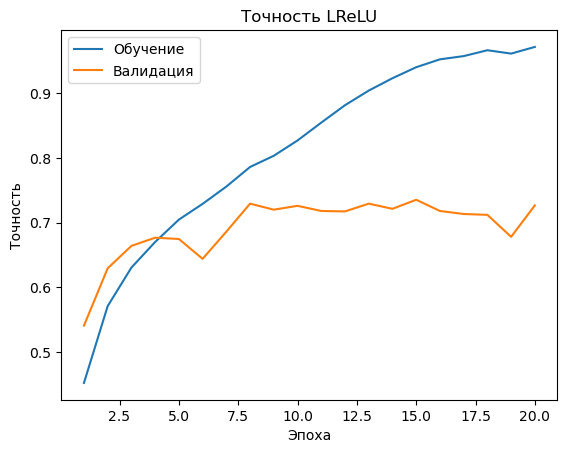

In [94]:
plt.title('Точность LReLU')
plt.plot(np.arange(1, 20+1, dtype=np.int16), resultsLReLU['mean_train_accs'], label='Обучение')
plt.plot(np.arange(1, 20+1, dtype=np.int16), resultsLReLU['mean_val_accs'], label='Валидация')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
# plt.semilogy()

In [51]:
resultsELU = train_multiple_runs(
    runs=3,
    model_constructor=makeELU,
    optimizer_constructor=make_optimizer,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=20,
)


===== Run 1/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 50.98it/s]



===== Run 2/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 77.00it/s]



===== Run 3/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 71.24it/s]


In [52]:
resultsGELU = train_multiple_runs(
    runs=3,
    model_constructor=makeGELU,
    optimizer_constructor=make_optimizer,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=20,
)


===== Run 1/3 =====


Training epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validating: 100%|██████████| 32/32 [00:00<00:00, 74.44it/s]



===== Run 2/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 69.80it/s]



===== Run 3/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 77.22it/s]


Посмотрим на историю точности валидации для каждой из моделей

Text(0, 0.5, 'Точность')

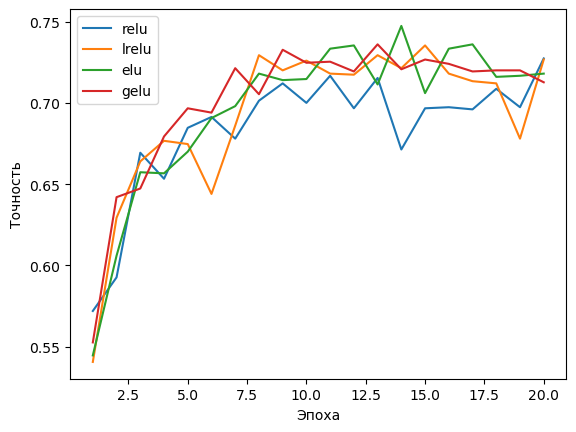

In [53]:
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.uint16), resultsRELU['mean_val_accs'], label='relu')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.uint16), resultsLReLU['mean_val_accs'], label='lrelu')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.uint16), resultsELU['mean_val_accs'], label='elu')
plt.plot(np.arange(1, EPOCH_NUM+1, dtype=np.uint16), resultsGELU['mean_val_accs'], label='gelu')
plt.legend()
plt.xlabel("Эпоха")
plt.ylabel("Точность")

In [54]:
print("RELU: ", resultsRELU['best_val_acc'])
print("LRELU: ", resultsLReLU['best_val_acc'])
print("ELU: ", resultsELU['best_val_acc'])
print("GELU: ", resultsGELU['best_val_acc'])

RELU:  0.756
LRELU:  0.758
ELU:  0.764
GELU:  0.758


Результаты довольно близкие, LeakyReLU и GELU показали похожие результаты, можем взять любую из моделей, у ELU получился наилучший результат, но c этой функцией активации модель обучалась дольше всего и она обучалась не так долго, можем взять ELU.

## Часть 4: Финальная модель и тестирование

### 4.1: Создание финальной модели

Лучшей вариацией стала неглубокая модель с тремя блоками, использующая ELU. Неглубокая модель показала наилучший результат. Это можно объяснить лишь тем, что выбранные случайно классы скорее всего оказались легко различимы для модели, поэтому не нужно строить сложные архитектуры. Также мы в принципе классифицируем всего лишь десять классов, что не так уж и много.

Сделаем снова три прогона обучения модели, как итоговую выберем наилучший результат среди всех прогонов и посмотрим на усреднённые графики обучения. Дополнительно добавим аугментацию поворота и отражения в обучающую выборку, также попробуем использовать AdamW

In [55]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = SmallDataset(root=data_root, classes=selected_classes,
                          ds_type='train', transform=train_transforms, device=device)
train_data_loader = DataLoader(train_data,batch_size=16, shuffle=True)

In [56]:
def initAdamW(model):
    return torch.optim.AdamW(model.parameters(), lr=1e-3, 
                             weight_decay=1e-4)

In [58]:
resultsFinal = train_multiple_runs(
    runs=3,
    model_constructor=makeELU,
    optimizer_constructor=initAdamW,
    criterion=criterion,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    epoch_num=40,
)


===== Run 1/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 58.26it/s]



===== Run 2/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 75.89it/s]



===== Run 3/3 =====


Validating: 100%|██████████| 32/32 [00:00<00:00, 79.91it/s]


Построим графики

Text(0, 0.5, 'Ошибка')

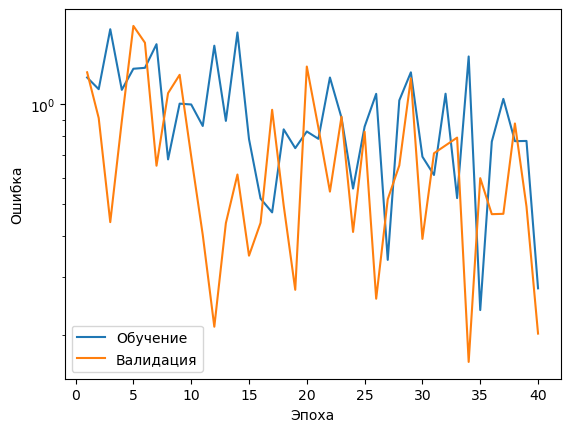

In [59]:
plt.plot(np.arange(1, 41, dtype=np.uint16), resultsFinal['mean_train_losses'], label='Обучение')
plt.plot(np.arange(1, 41, dtype=np.uint16), resultsFinal['mean_val_losses'], label='Валидация')
plt.legend()
plt.semilogy()
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')

Text(0, 0.5, 'Точность')

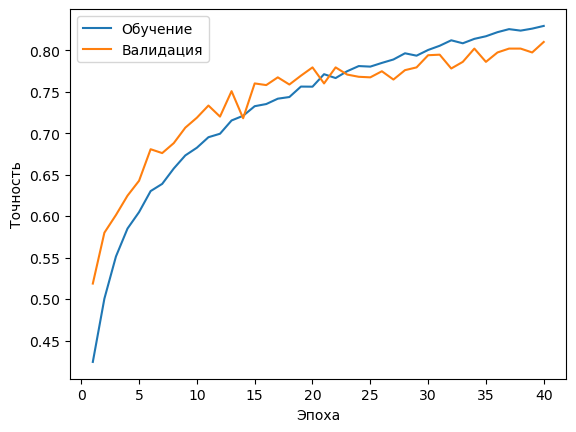

In [60]:
plt.plot(np.arange(1, 41, dtype=np.uint16), resultsFinal['mean_train_accs'], label='Обучение')
plt.plot(np.arange(1, 41, dtype=np.uint16), resultsFinal['mean_val_accs'], label='Валидация')
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('Точность')

Лучшая точность

In [61]:
print(resultsFinal['best_val_acc'])

0.826


Мы смогли получить лучшую точность на финальной модели

In [62]:
best_model = resultsFinal['best_model']

Визуализируем ещё метрики

In [63]:
best_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, targets, _ in val_data_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, dim=1)

        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


In [64]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79        50
           1       0.92      0.90      0.91        50
           2       0.73      0.88      0.80        50
           3       0.82      0.82      0.82        50
           4       0.90      0.76      0.83        50
           5       0.89      0.84      0.87        50
           6       0.67      0.78      0.72        50
           7       0.84      0.92      0.88        50
           8       0.84      0.92      0.88        50
           9       0.88      0.70      0.78        50

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



In [ ]:
transforms_list = transforms.Compose([
    transforms.ToTensor()])
val_data_orig = SmallDataset(root=data_root, classes=selected_classes,
                        ds_type='val', transform=transforms_list, device=device)
def get_one_example_per_class(num_classes):
    examples = []
    seen = set()
    for i in range(len(val_data)):
        img_norm, label, _ = val_data[i]
        img, label, _ = val_data_orig[i]
        label_idx = label.item() if torch.is_tensor(label) else label
        if label_idx not in seen:
            examples.append((img, img_norm, label_idx))
            seen.add(label_idx)
            if len(examples) == num_classes:
                break
    return examples

num_classes = 10
examples = get_one_example_per_class(num_classes)

In [67]:
with open('./data/tiny-imagenet-200/tiny-imagenet-200/words.txt', 'r') as f:
    rows = f.readlines()
    f.close()
rows = [row.split('	') for row in rows]
classes_set = set(selected_classes)
id_to_word = {}
for row in rows:
    id, word = row
    if id not in classes_set:
        continue
    id_to_word[id] = word.strip('\n')

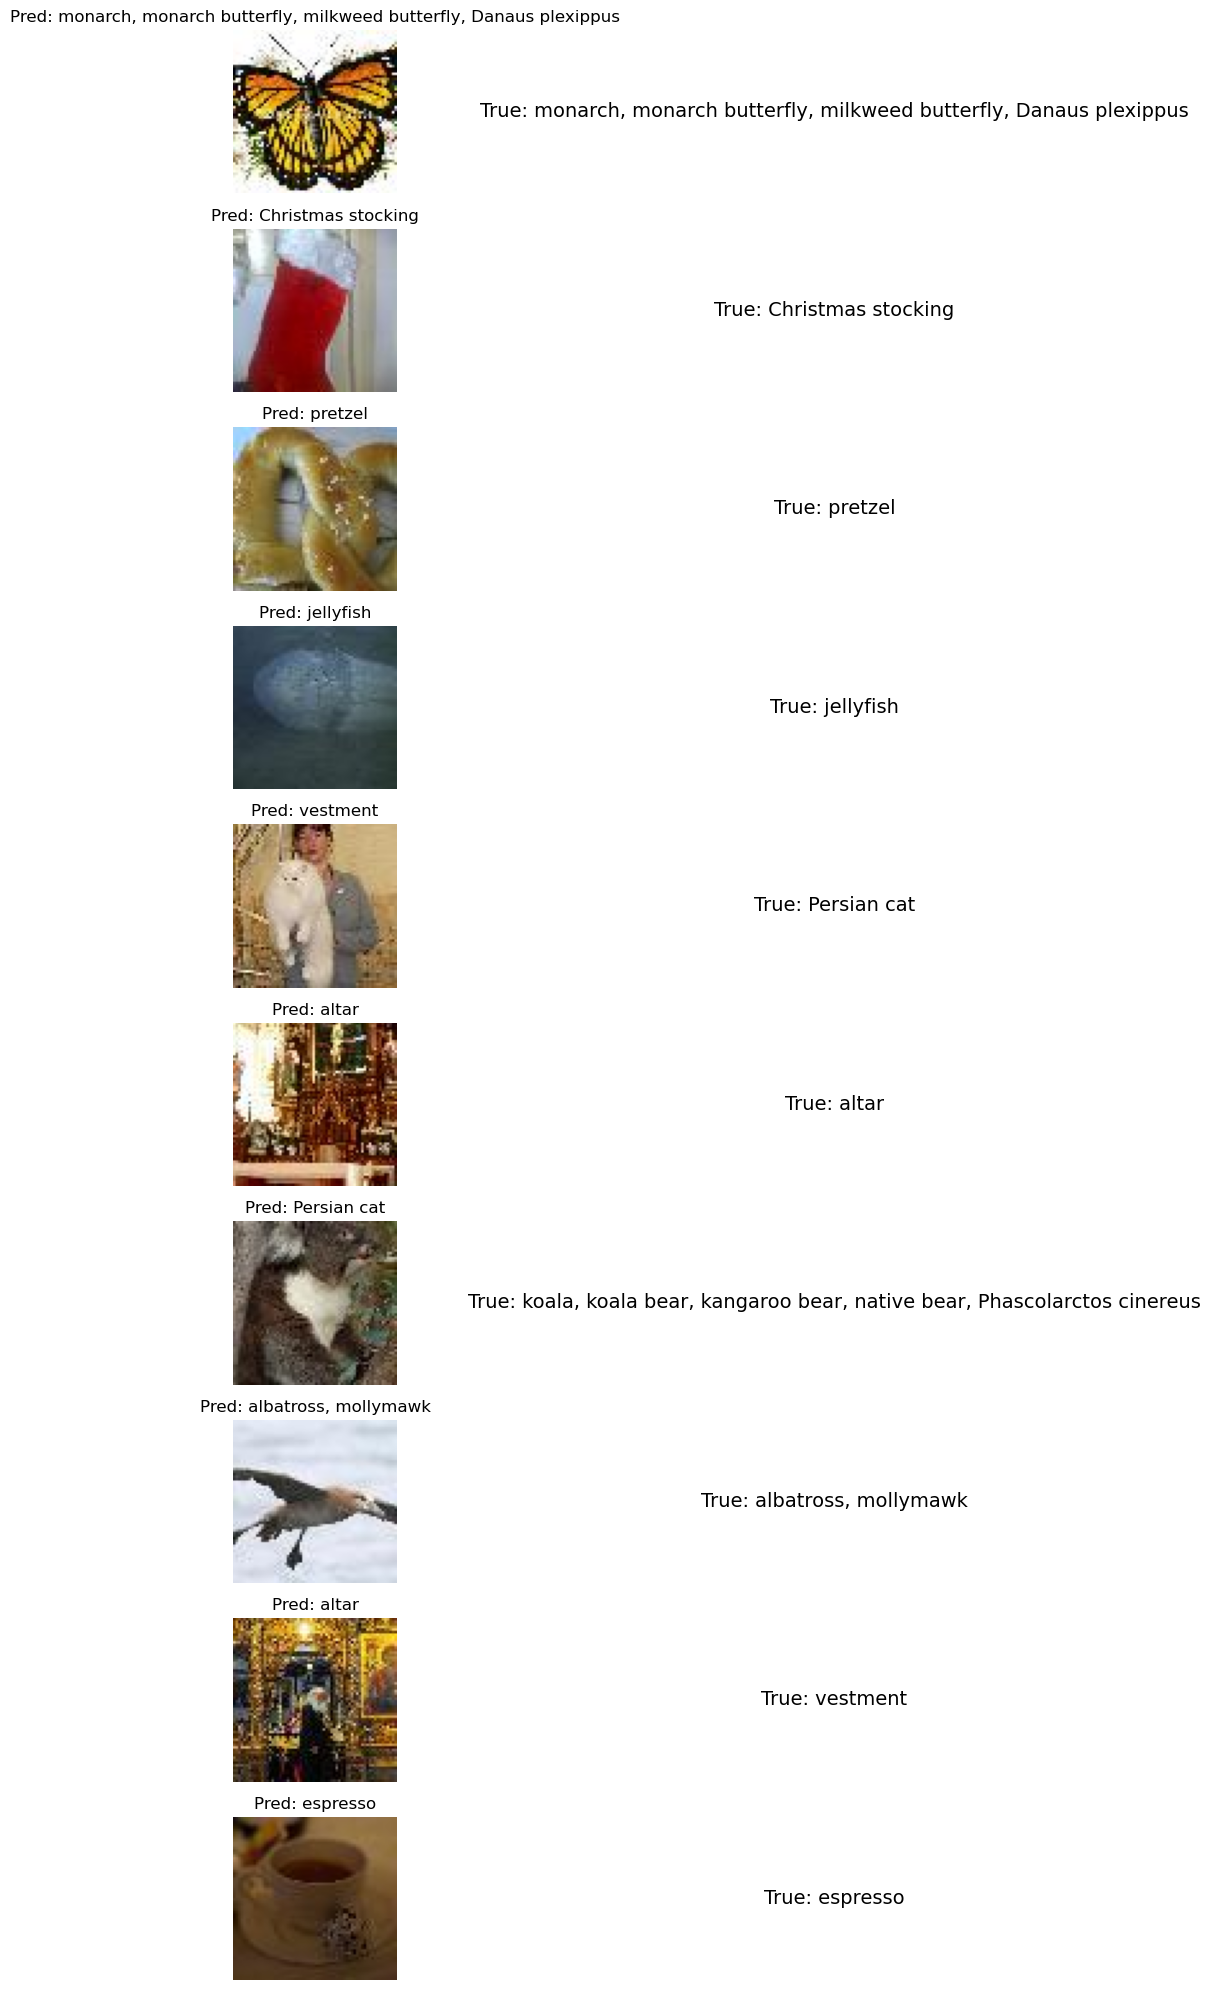

In [ ]:
import torchvision.transforms as T
import matplotlib.pyplot as plt

best_model.eval()

to_pil = T.ToPILImage()

predicted_labels = []
with torch.no_grad():
    for idx, (img, img_norm, true_label) in enumerate(examples):
        img_input = img_norm.unsqueeze(0).to(device)  # [1, C, H, W]
        output = best_model(img_input)
        pred = output.argmax(dim=1).item()
        predicted_labels.append(pred)
num_classes = len(examples)
plt.figure(figsize=(12, 2 * num_classes))
for idx, ((img, img_norm, true_label), pred_label) in enumerate(zip(examples, predicted_labels)):
    #изображение + предсказание
    plt.subplot(num_classes, 2, 2 * idx + 1)
    pil_img = to_pil(img.cpu())
    pred_name = id_to_word[selected_classes[pred_label]]
    plt.imshow(pil_img)
    plt.title(f"Pred: {pred_name}")
    plt.axis('off')
    
    #GT
    plt.subplot(num_classes, 2, 2 * idx + 2)
    true_name = id_to_word[selected_classes[true_label]]
    plt.text(0.5, 0.5, f"True: {true_name}", fontsize=14, ha='center', va='center')
    plt.axis('off')
plt.tight_layout()
plt.show()

Построим итоговую сводную таблицу

In [83]:
def getTrainAcc(results):
    trainAccs = np.array(results['all_histories']['train_accs'])
    valAccs = np.array(results['all_histories']['val_accs'])
    bestIdx = np.argmax(valAccs)
    idxRun = bestIdx // trainAccs.shape[1]
    idxEpoch = bestIdx % trainAccs.shape[1]
    return trainAccs[idxRun, idxEpoch]

In [87]:
print('Baseline точность: ', results['best_val_acc'])

Baseline точность:  0.704


In [86]:
initial_resnet = getTrainAcc(results)
print(initial_resnet)
resnet_a = getTrainAcc(resultsA)
print(resnet_a)
resnet_b = getTrainAcc(resultsB)
print(resnet_b)
resnet_shallow = getTrainAcc(resultsShallow)
print(resnet_shallow)
resnet_mid = getTrainAcc(resultsMid)
print(resnet_mid)
resnet_deep = getTrainAcc(resultsDeep)
print(resnet_deep)
resnet_relu = getTrainAcc(resultsRELU)
print(resnet_relu)
resnet_lrelu = getTrainAcc(resultsLReLU)
print(resnet_lrelu)
resnet_elu = getTrainAcc(resultsELU)
print(resnet_elu)
resnet_gelu = getTrainAcc(resultsGELU)
print(resnet_gelu)
resnet_final = getTrainAcc(resultsFinal)
print(resnet_final)

0.792
0.9404
0.7816
0.978
0.7472
0.8818
0.8448
0.893
0.858
0.973
0.8346


| Этап      | Конфигурация            | Параметры | Val Accuracy | Train Accuracy |
|----------|-------------------------|-----------|--------------|----------------|
| Baseline | Ваша базовая модель     | 4.1M      | 70.4%        | 79.2%          |
| 3.1-A    | 32→64→128→256           | 1.0M      | 70.8%        | 94.0%          |
| 3.1-B    | 64→128→256              | 0.9M      | 74.6%        | 78.2%          |
| 3.2-A    | [1,1,1] блоков        | 0.6M      | 76.6%        | 97.8%          |
| 3.2-B    | [2,2,2] блоков        | 0.9M      | 72.4%        | 74.7%          |
| 3.2-C    | [3,3,3] блоков        | 1.3M      | 72.0%        | 88.2%          |
| 3.3-A    | ReLU                    | 0.6M      | 75.6%        | 84.5%          |
| 3.3-B    | LeakyReLU               | 0.6M      | 75.8%        | 89.3%          |
| 3.3-C    | ELU                     | 0.6M      | 76.4%        | 85.8%          |
| 3.3-D    | GELU                    | 0.6M      | 75.8%        | 97.3%          |
| Final    | Лучшая конфигурация (ELU + аугментация + AdamW)     | 0.6M      | 82.6%        | 83.5%          |


# Выводы

Было обучено множество различных конфигураций модели ResNet. Наилучшей себя показала самая неглубокая модель. Скорее всего это связано с маленьким количеством классов и небольшим размером изображений. Улучшение модели при помощи изменения функции активации не показало сильного выигрыша, однако получилось слегка улучшить результаты. Самым главным преимуществом оказалась настройка гиперпараметров. При помощи использования AdamW удалось значительно улучшить точность модели, благодаря чему она обучалась на всех эпохах. Если смотреть на графики всех предыдущих результатов, то обучение останавливалось примерно на середине обучения, далее точность валидации не возрастала.

Модель показала эффективность более 80% и почти на всех классах она работала одинаково хорошо. Можно наблюдать проседание в точности только на классе vestment (облачение). Скорее всего модель часто путает это изображение с altar, так как скорее всего облачения всегда встречались на фоне алтаря.

Благодаря проведению множества оптимизаций нам удалось уменьшить размер базовой модели почти что в семь раз, при этом мы смогли повысить точность модели на 12%. Настройка гиперпараметров является неотъемлемой частью процесса оптимизации моделей.